# Age Prediction with a Convolutional Neural Network

Predicting a persons age from one image is challenging, especially for a single network to grasp.
This notebook utilises _feature fusion_ with multiple Covolutional Neural Networks (CNNs) to predict the generation people ranging from ages 1-116 belong to.

The model has 3 branches to enhance its performance. As people may look different in different lighting scenarios, the first branch extracts features from the unaltered image, the next branch extracts features from the image which has been synthetically brightened, and the third branch extracts features from the image after being darkened. 

Over-altered images will degrade model performance so image manipulation techniques aim to keep inputs looking realistic.

By fusing extracted features, the model gets a better overall representation of the image and should be able to better predict the subjects age.



## Imports

In [2]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import time
from PIL import ImageFile, Image

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline


## Create Dataset

All images are saved together in a folder, `Data/Faces Grouped/`. <br>
The labels are contained in the file names with the format `[age]_[gender]_[race]_[date&time].jpg`

Labels and images are paired to create the dataset for training the model.

In [3]:
"""
Global dictionary.
Used to map generations to an integer representation.
"""
AGE_TO_INT = {
    'Gen Alpha': 0,
    'Gen Z': 1,
    'Millenial': 2,
    'Gen X': 3,
    'Baby Boomer': 4,
    'Post War': 5,
    'WWII': 6
}

def get_generation(age: int):
    """
    Maps a subjects age to their generation.
    Generational groups sourced at:
        https://www.beresfordresearch.com/age-range-by-generation/

    Args:
        age (int): The age of the subject

    Returns:
        int: Integer representing a generation.
    """
    if 0 <= age <= 11:
        return AGE_TO_INT['Gen Alpha']
    elif 12 <= age <= 26:
        return AGE_TO_INT['Gen Z']
    elif 27 <= age <= 42:
        return AGE_TO_INT['Millenial']
    elif 43 <= age <= 58:
        return AGE_TO_INT['Gen X']
    elif 59 <= age <= 77:
        return AGE_TO_INT['Baby Boomer']
    elif 78 <= age <= 95:
        return AGE_TO_INT['Post War']
    else:
        return AGE_TO_INT['WWII']



def split_data(data: str):
    """
    Extracts label/image pairs from the total data and creates 
        training, validation and testing sets.
    The total dataset is shuffled before the subsets are made.

    Args:
        data (str): File path to the folder containing all the images.

    Returns:
        train, val, test (list, list, list): training, validation and
            testing sets.
    """
    # Gets full file name
    file = [file_name for file_name in os.listdir(data) if 
              file_name.endswith('.jpg')]
    # Extracts subject age from the file name
    label = [get_generation(int(label.split('_')[0])) for label in file]
    # Pairs labels with images
    dataset = zip(label, file)
    dataset = list(dataset)
    random.shuffle(dataset)
    split_80 = int(len(dataset)*0.8)
    split_10 = int((len(dataset)-split_80)/2)
    # first 80% of data is for training
    train = dataset[: split_80]
    # next 10% for validation
    val = dataset[split_80 : split_80 + split_10]
    # final 10% for testing
    test = dataset[split_80 + split_10 : (split_80 + (split_10*2))]
    return train, val, test

file_path = 'Data/Faces Grouped'
raw_train, raw_val, raw_test = split_data(file_path)

## Overload PyTorch Dataset

Overloading the Dataset class enables rewriting of the `__getitem__()` function. This is how the DataLoader is able to retrieve three, differently transformed, images as well as the label when collecting the data for each batch.

In [4]:
class ModelDataset(Dataset):
    """
    Overloads the PyTorch Dataset class.
    Enables transformations to be applied to an image and its copies
      before they are presented to the model.

    Args:
        Dataset (Dataset): Map from index to data sample.
    """
    def __init__(self, data):
        """
        Initialises the transforms and stores the data

        Args:
            data (list[int, str]): label and its 
                corresponding image path.
        """
        
        self.data = data
        
        self.general_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Pad(padding=4, fill=(0,0,0), padding_mode='constant'),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
        ])
        self.brighten_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.3, 
                                   contrast=0.2, 
                                   saturation=0.4),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.Pad(padding=4, fill=(0,0,0), padding_mode='constant'),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
        ])
        self.darken_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=(0.5, 1), 
                                   contrast=(0.7, 1), 
                                   saturation=(0.7, 1)),
            transforms.ColorJitter(hue=0.1),
            transforms.Pad(padding=4, fill=(0,0,0), padding_mode='constant'),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        """
        Copies the image and applies transformations to it.
        Returns the label, original image, 
            a brightened and a darkened variant from a specified index.
        Images retrieved are normalized tensors.

        Args:
            index (int): Index to retrieve data

        Returns:
            label, image, brightened_image, darkened_image 
            (int, torch.Tensor, torch.Tensor, torch.Tensor): 
                label and transformed images.
        """
        path = os.path.join('Data/Faces Grouped/', self.data[index][1])
        label = self.data[index][0]
        image = Image.open(path).convert("RGB")
        brightened_image = self.brighten_transforms(image)
        darkened_image = self.darken_transforms(image)
        image = self.general_transforms(image)
        return label, image, brightened_image, darkened_image

## Define Transforms and Create Datasets

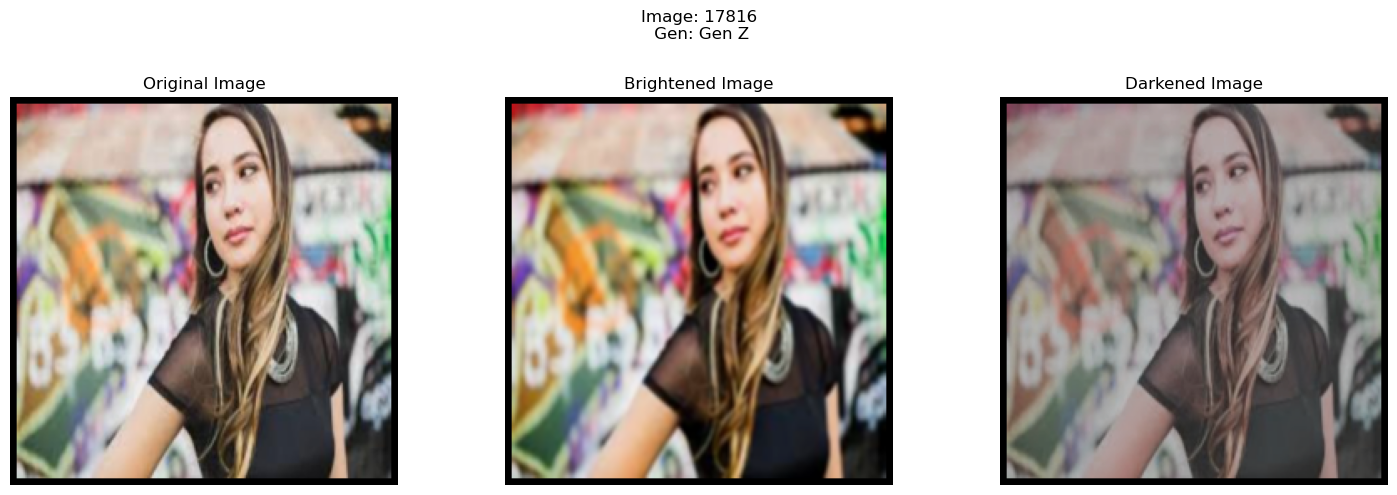

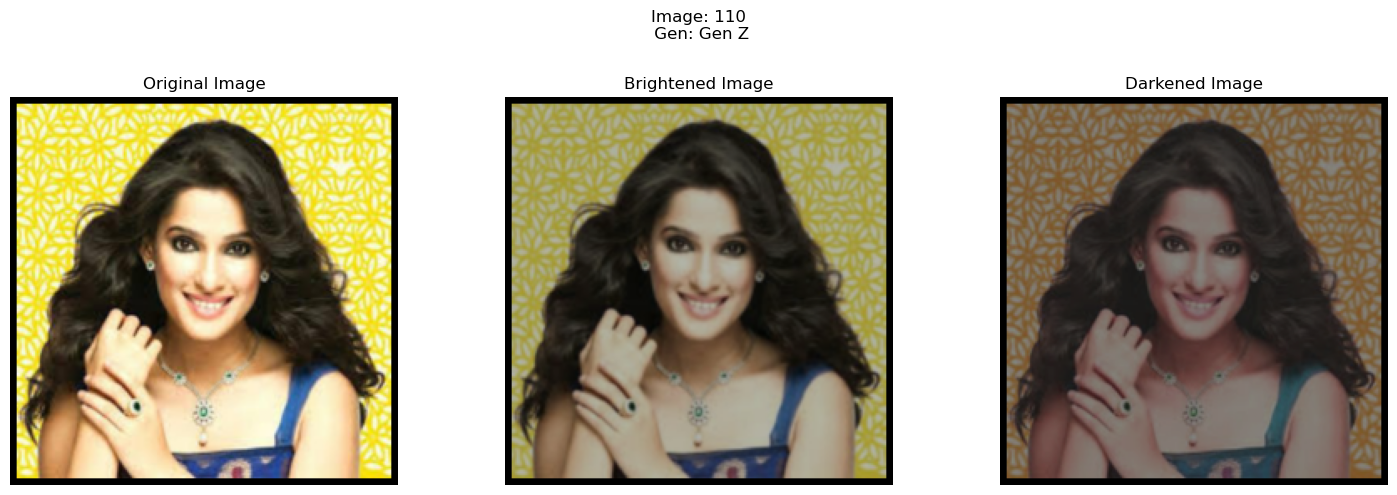

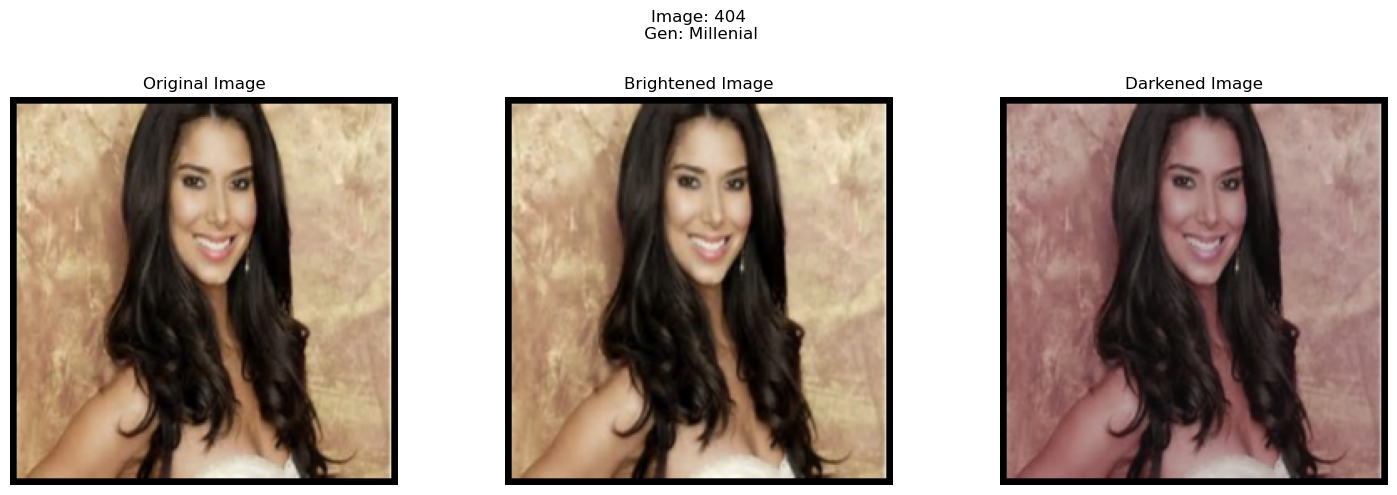

In [5]:
# Create datasets
train_data = ModelDataset(raw_train)
val_data = ModelDataset(raw_val)
test_data = ModelDataset(raw_test)

def show_image(data: Dataset):
    """
    Displays the label and set of images from a random sample.

    Args:
        data (Dataset): Dataset to select random sample from.
    """
    def denormalize(image):
        """
        Reverses the normalisation applied to the image.

        Args:
            image (torch.Tensor): Tensor representing the image.

        Returns:
            (torch.Tensor): _description_
        """
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return image * std + mean
    
    idx = random.randint(0, len(data))
    label, image, b_image, d_image = data.__getitem__(idx)
    image_denorm = denormalize(image)
    b_image_denorm = denormalize(b_image)
    d_image_denorm = denormalize(d_image)

    keys = list(AGE_TO_INT.keys())
    gen = keys[label]

    title = f'Image: {idx}\n Gen: {gen}\n\n'
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].imshow(image_denorm.permute(1,2,0))
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    axs[1].imshow(b_image_denorm.permute(1,2,0))
    axs[1].axis('off')
    axs[1].set_title('Brightened Image')
    axs[2].imshow(d_image_denorm.permute(1,2,0))
    axs[2].axis('off')
    axs[2].set_title('Darkened Image')
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

show_image(train_data)
show_image(val_data)
show_image(test_data)

In [6]:
def plot_metrics(t_metric, v_metric, metric, num_epochs):
    """
    Displays accuracy and validation metrics plotted on line graphs.

    Args:
        t_metric (list): Accuracy/loss values during training.
        v_metric (list): Accuracy/loss values during validation.
        metric (str): Type of metric being plotted
        num_epochs (int): Number of epochs the model was trained.
    """
    plt.plot(t_metric, c='blue', label=f'Training')
    plt.plot(v_metric, c='red', label=f'Validation')
    plt.ylabel(f'{metric.title()}')
    plt.xlabel('Epoch')
    plt.title(f'{metric.title()} over {num_epochs} epochs')
    plt.legend()
    plt.show()

def train(dataloader, 
          model, 
          optimizer, 
          scheduler, 
          criterion,
          device, 
          epoch, 
          verbose=True):
    """
    Used to train a neural network.
    Sets the model to training mode and initialises variables to keep 
    track of metrics during training.
    Iterates through label/text pairs from each dataset making label
    predictions. 
    Calculates loss and backpropagates parameter updates
    through the network to ideally reduce loss over epochs.

    Args:
        dataloader (DataLoader): DataLoader containing training
            data.
        model (nn.Module): The LSTM model being trained.
        optimizer (torch.optim.sgd): Backpropagation method.
        criterion (torch.nn.modules.loss): Loss function.
        epoch (int): The current epoch.
        verbose (Boolean): Display metrics (default=True).

    Returns:
        epoch_loss, epoch_accuracy, epoch_count 
            (float, float, int): loss, accuracy and number of 
            predictions made in one epoch.
    """
    model.train()
    # Accuracy and loss of each prediction
    accuracy, loss = 0, 0
    # Accuracy and loss accumulated over epoch
    total_accuracy, total_loss = 0, 0
    # Number of predictions
    num_predictions = 0
    # Displays training metrics every quarter of epoch
    intervals = (len(dataloader) / 4).__round__()
    for idx, (label, 
              original_img, 
              bright_img, 
              dark_img) in enumerate(dataloader):
        original_img = original_img.to(device, dtype=torch.float32)
        bright_img = bright_img.to(device, dtype=torch.float32)
        dark_img = dark_img.to(device, dtype=torch.float32)
        label=label.to(device, dtype=torch.long)
        # Make prediction
        prediction = model(original_img, bright_img, dark_img)
        # Calculate loss
        loss = criterion(prediction, label)
        _, predicted_classes = torch.max(prediction, 1)
        batch_loss = loss.item()
        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Store metrics
        accuracy += (predicted_classes == label).sum().item()
        total_loss += batch_loss
        num_predictions += label.size(0)
        total_accuracy += accuracy

        if verbose and idx % intervals == 0 and idx > 0:
            epoch_metrics = (
                f'| Epoch {epoch + 1} |' 
                f'{idx:5} / {len(dataloader):5} batches |' 
                f'{(accuracy/num_predictions)*100:.10f}% accurate |'
                )
            print(epoch_metrics)
            accuracy = 0
            num_predictions = 0
    scheduler.step()
    return total_loss, total_accuracy, num_predictions

def evaluate(dataloader, model, criterion, device):
    """
    Used to evaluate model training.
    Works similarly to the training method, allowing the model
    to make predictions on labelled data, however no parameters are
    updated.

    Args:
        dataloader (DataLoader): DataLoader containing either validation
            or testing data.
        model (nn.Module): The LSTM model being trained.
        criterion (torch.nn.modules.loss): Loss function.

    Returns:
        batch_loss, batch_accuracy, batch_count 
            (float, float, int): loss, accuracy and number of 
            predictions made over the validation set.
    """
    model.eval()
    total_accuracy = 0
    total_count = 0
    total_loss = 0
    with torch.no_grad():
        for idx, (label, 
                  original_img, 
                  bright_img, 
                  dark_img) in enumerate(dataloader):
            original_img = original_img.to(device, dtype=torch.float32)
            bright_img = bright_img.to(device, dtype=torch.float32)
            dark_img = dark_img.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)
            prediction = model(original_img, bright_img, dark_img)
            loss = criterion(prediction, label)
            _, predicted_classes = torch.max(prediction, 1)
            total_accuracy += (predicted_classes == label).sum().item()
            total_count += label.size(0)
            total_loss += loss.item()
    return total_loss, total_accuracy, total_count

def model_env(training, 
              validation, 
              testing, 
              model, 
              optimizer,
              scheduler, 
              criterion,
              device, 
              epochs, 
              verbose=True):
    """
    Wraps the training and evaluation functions in one method.
    At the end of each epoch, the model asseses the validation set.
    Once all epochs are complete performance is assesed on the test set.

    Args:
        training (DataLoader): DataLoader with training data.
        validation (DataLoader): DataLoader with validation data.
        testing (DataLoader): DataLoader with testing data.
        model (nn.Module): The LSTM model being trained.
        optimizer (torch.optim.sgd): Backpropagation method.
        criterion (torch.nn.modules.loss): Loss function.
        epochs (int): Number of epochs the model is trained for.
        verbose (Boolean): Display metrics (default=True).

    Returns:
        train_accuracy, train_loss, val_accuracy, val_loss 
            (list, list, list, list): Metrics saved during training and
            evaluation.
    """
    # Containers for training and evaluation metrics
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    # Time saved for calculating final processing time
    start_time = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        print('-' * 59)
        print(f'|\t\t         Epoch {epoch + 1}             \t\t  |')
        print('-' * 59)
        # Process training data
        loss, acc, count = train(training, 
                                 model, 
                                 optimizer,
                                 scheduler, 
                                 criterion,
                                 device, 
                                 epoch, 
                                 verbose)  
        # Store training metrics
        train_loss.append(loss)
        train_accuracy.append(acc)
        # Evaluate validation data
        loss, acc, count = evaluate(validation, 
                                    model, 
                                    criterion, 
                                    device)
        # Store evaluation metrics
        val_loss.append(loss)
        val_accuracy.append(acc)
        val_ratio = (acc/count)*100
        print('-' * 59)
        epoch_metrics = (
            f'| End of epoch {epoch + 1} |'
            f'Time: {time.time() - epoch_start:.2f}s |'
            f'Acc: {val_ratio:.14f}%  |'
        )
        print(epoch_metrics)
        print('-' * 59)
        print()
    # Assess model performance on test data
    loss, acc, count = evaluate(testing, model, criterion, device)
    test_ratio = (acc/count)*100
    total_time = (time.time() - start_time).__round__()/60
    print('*' + '-' * 57 + '*')
    test_metrics = (
        f'*\t\t\tTesting Epoch\t\t\t  *\n'
        f'*' + '-' * 57 + '*\n'
        f'* \t\t      Time: {total_time:.2f} minutes\t\t  *\n'
        f'*\t\t    Acc: {test_ratio:.14f}%            \t  *'
    )
    print(test_metrics)
    print('*' + '-' * 57 + '*')
    return train_accuracy, train_loss, val_accuracy, val_loss

In [7]:
class MultiBranchAgePrediction(nn.Module):
    def __init__(self):
        super(MultiBranchAgePrediction, self).__init__()

        self.branch = nn.Sequential(
            nn.Conv2d(3, 24, 3, stride=1, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(3*24, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(64, 21),
            nn.BatchNorm1d(21),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(21, 7)
            )
        
    def forward(self, original_x, bright_x, dark_x):
        out_original = self.branch(original_x).view(original_x.size(0), -1)
        out_bright = self.branch(bright_x).view(bright_x.size(0), -1)
        out_dark = self.branch(dark_x).view(dark_x.size(0), -1)
        out = torch.cat((out_original, out_bright, out_dark), dim=1)
        out = self.classifier(out)
        prediction = out.squeeze(1)
        return prediction


In [12]:
def set_device():
    """
    Device used to process tensors.
    """
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            return torch.device("mps")
    else:
        return torch.device("cpu")
    
device = set_device()
model = MultiBranchAgePrediction().to(device, dtype=torch.float32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, verbose=True)

params = sum(p.numel() for p in model.parameters())
print(f"CNN has {params} parameters.")

Adjusting learning rate of group 0 to 1.0000e-04.
CNN has 20265 parameters.


In [13]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

epochs = 30
t_acc, t_loss, v_acc, v_loss = model_env(
    train_loader,
    val_loader,
    test_loader,
    model,
    optimizer,
    scheduler,
    criterion,
    device,
    epochs,
    verbose=True
)

-----------------------------------------------------------
|		         Epoch 1             		  |
-----------------------------------------------------------
| Epoch 1 |   76 /   302 batches |12.1753246753% accurate |
| Epoch 1 |  152 /   302 batches |18.2976973684% accurate |
| Epoch 1 |  228 /   302 batches |22.3273026316% accurate |
Adjusting learning rate of group 0 to 1.0000e-04.
-----------------------------------------------------------
| End of epoch 1 |Time: 407.71s |Acc: 27.12567399419328%  |
-----------------------------------------------------------

-----------------------------------------------------------
|		         Epoch 2             		  |
-----------------------------------------------------------
| Epoch 2 |   76 /   302 batches |25.8116883117% accurate |
| Epoch 2 |  152 /   302 batches |28.2894736842% accurate |
| Epoch 2 |  228 /   302 batches |29.4613486842% accurate |
Adjusting learning rate of group 0 to 1.0000e-04.
-------------------------------------------

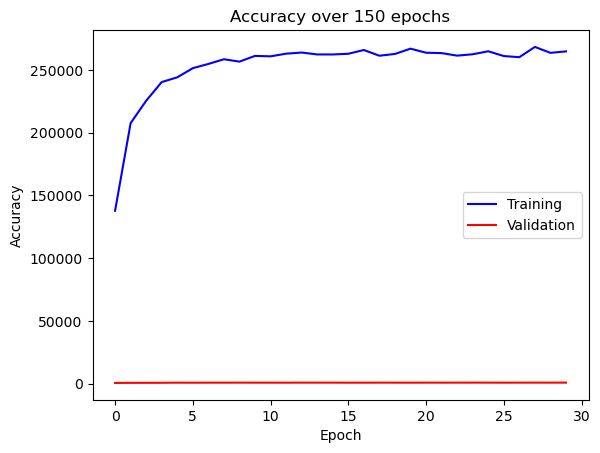

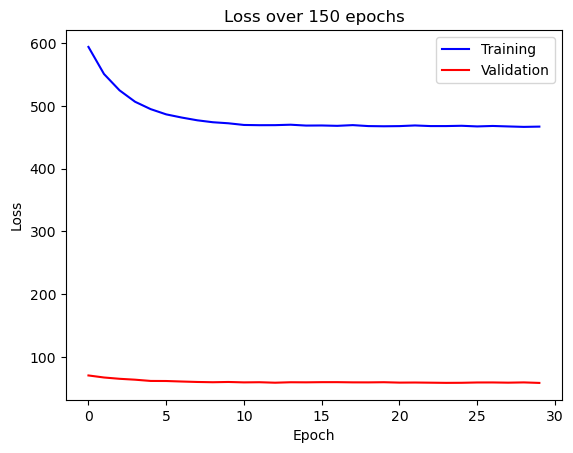

In [14]:
plot_metrics(t_acc, v_acc, 'Accuracy', 150)
plot_metrics(t_loss, v_loss, 'Loss', 150)